In [1]:
import utils
import datetime
import pandas as pd
import instrument
import plotly.graph_objects as go

BUY = 1
SELL = -1

In [2]:
def create_candle_plot(df_plot, range=None, start=None):
    fig = go.Figure()
    fig.add_trace(go.Candlestick(
        x=df_plot.time, open=df_plot.mid_o, high=df_plot.mid_h, low=df_plot.mid_l, close=df_plot.mid_c,
        line=dict(width=1), opacity=1,
        increasing_fillcolor='#24A06B',
        decreasing_fillcolor="#CC2E3C",
        increasing_line_color='#2EC886',  
        decreasing_line_color='#FF3A4C'
    ))
    if range is not None:
        delta = range[1] - range[0]
        # fig.add_hline(y=(range[0] - delta), line_width=2, line_dash="dash", line_color="red")
        # fig.add_hline(y=(range[1] + delta), line_width=2, line_dash="dash", line_color="green")
        fig.add_hline(y=range[0], line_width=2, line_dash="dash", line_color="yellow")
        fig.add_hline(y=range[1], line_width=2, line_dash="dash", line_color="yellow")
        
    if start is not None:
        fig.add_vline(x=start, line_width=2, line_dash="dash", line_color="blue")
    
    fig.update_layout(width=1000,height=300,
        margin=dict(l=10,r=10,b=10,t=10),
        font=dict(size=10,color="#e1e1e1"),
        paper_bgcolor="#1e1e1e",
        plot_bgcolor="#1e1e1e")
    fig.update_xaxes(
        gridcolor="#1f292f",
        showgrid=True,fixedrange=True,rangeslider=dict(visible=False)
    )
    fig.update_yaxes(
        gridcolor="#1f292f",
        showgrid=True
    )
    fig.show()

In [34]:
def get_date_as_string(df):
    return df.loc[(len(df.index) - 1), "time"].strftime("%Y-%m-%d")


def get_price_data(pairname, granularity):
    df = pd.read_pickle(utils.get_his_data_filename(pairname, granularity))
    non_cols = ["time", "volume"]
    mod_cols = [x for x in df.columns if x not in non_cols]
    df[mod_cols] = df[mod_cols].apply(pd.to_numeric)
    return df[["time", "mid_o", "mid_h", "mid_l", "mid_c"]]


def get_day_data(date, price_data):
    start_time = date - datetime.timedelta(hours=2)
    end_time = date + datetime.timedelta(days=1)
    df_day = price_data[
        (price_data.time >= start_time) & (price_data.time < end_time)
    ].copy()
    df_day.dropna(inplace=True)
    df_day.reset_index(drop=True, inplace=True)
    return df_day


def get_post_london_open_data(df):
    day = get_date_as_string(df)
    london_start_time = utils.get_utc_dt_from_string(f"{day} 07:00:00+00:00")
    df_post_london_open = df[(df.time >= london_start_time)].copy()
    df_post_london_open.reset_index(drop=True, inplace=True)
    return df_post_london_open


def calculate_london_start_time(day):
    return utils.get_utc_dt_from_string(f"{day} 07:00:00+00:00")


def calculate_tokyo_start_time(day):
    return utils.get_utc_dt_from_string(f"{day} 00:30:00+00:00")


def calculate_pre_open_range(df_day):
    date = utils.get_utc_dt_from_string(get_date_as_string(df_day))
    tokyo_open_time = calculate_tokyo_start_time(date)
    df_pre_tokyo_open = df_day[(df_day.time < (tokyo_open_time))].copy()  #datetime.timedelta(hours=3)))].copy()
    range_max = max(df_pre_tokyo_open.mid_h.max(), df_pre_tokyo_open.mid_l.max())
    range_min = min(df_pre_tokyo_open.mid_h.min(), df_pre_tokyo_open.mid_l.min())
    return range_min, range_max


def calculate_take_profit(position_type, range_max, range_min):
    delta = range_max - range_min
    if position_type == BUY:
        take_profit = range_max + 4.0*delta
    elif position_type == SELL:
        take_profit = range_min - 4.0*delta
    return take_profit    


def calculate_stop_loss(position_type, range_max, range_min):
    delta = range_max - range_min
    if position_type == BUY:
        stop_loss = range_min + delta/2
    elif position_type == SELL:
        stop_loss = range_max - delta/2
    return stop_loss

In [35]:
def get_close_time_as_string(df):
    close_time = df.loc[(len(df.index) - 1), "time"].strftime("%H:%M:%S")
    return close_time

def exit_time(df):
    return utils.get_utc_dt_from_string(
        f"{get_date_as_string(df)} {get_close_time_as_string(df)}"
    )

def count_open_trades(df):
    buy_list = [x for x in df.IS_TRADE if x == BUY]
    sell_list = [x for x in df.IS_TRADE if x == SELL]
    buys = len(buy_list)
    sells = len(sell_list)
    return {"total": (buys + sells), "buys": buys, "sells": sells}

def over_range_max(row, range_max):
    return row.mid_h > range_max

def under_range_min(row, range_min):
    return row.mid_l < range_min

def get_past_data(df, index):
    return df.iloc[:index].copy()

def over_take_profit(row, take_profit):
    return row.mid_h > take_profit

def over_stop_loss(row, stop_loss):
    return row.mid_h > stop_loss

def under_take_profit(row, take_profit):
    return row.mid_l < take_profit

def under_stop_loss(row, stop_loss):
    return row.mid_l < stop_loss

def calculate_trades(df, range_min, range_max):
    df["IS_TRADE"] = 0
    for index, row in df.iterrows():
        trade_count = count_open_trades(get_past_data(df, index))
        if trade_count["total"] == 0:
            if over_range_max(row, range_max):
                df.loc[index, "IS_TRADE"] = BUY
            elif under_range_min(row, range_min):
                df.loc[index, "IS_TRADE"] = SELL
        elif trade_count["total"] == 1:
            if trade_count["buys"] == 1:
                if over_take_profit(row, calculate_take_profit(BUY, range_max, range_min)):
                    df.loc[index, "IS_TRADE"] = SELL
                elif under_stop_loss(row, calculate_stop_loss(BUY, range_max, range_min)):
                    df.loc[index, "IS_TRADE"] = SELL
            elif trade_count["sells"] == 1:
                if under_take_profit(row, calculate_take_profit(SELL, range_max, range_min)):
                    df.loc[index, "IS_TRADE"] = BUY
                elif over_stop_loss(row, calculate_stop_loss(SELL, range_max, range_min)):
                    df.loc[index, "IS_TRADE"] = BUY
        if row.time >= exit_time(df) and trade_count['total'] == 1:
            if trade_count["buys"] == 1:
                df.loc[index, "IS_TRADE"] = SELL
            if trade_count["sells"] == 1:
                df.loc[index, "IS_TRADE"] = BUY
    return df

def process_trades(df, i_pair):
    df_trades = df[df.IS_TRADE != 0].copy()
    df_trades["DELTA"] = df_trades.mid_h.diff() / i_pair.pipLocation # TODO: this line is inaccurate!! 
    df_trades["GAIN"] = df_trades["DELTA"] * df_trades["IS_TRADE"] * (-1)
    return df_trades

In [24]:
def test_trade(date, pairname, granularity):
    price_data = get_price_data(pairname, granularity)
    i_pair = instrument.Instrument.get_instruments_dict()[pairname]
    date = utils.get_utc_dt_from_string(date)
    tokyo_open = date + datetime.timedelta(hours=1) 
    df = get_day_data(date, price_data) 
    range_min, range_max = calculate_pre_open_range(df)
    print(range_max, range_min)
    df.reset_index(drop=True, inplace=True)
    df = calculate_trades(df, range_min, range_max)
    df_trades = process_trades(df, i_pair)
    create_candle_plot(df, range=(range_min, range_max), start=tokyo_open)
    return df_trades


In [6]:
granularity = "M15"
date = "2022-10-14"
pairname = 'GBP_JPY'
test_trade(date, pairname, granularity)

166.88 166.367


,time,mid_o,mid_h,mid_l,mid_c,IS_TRADE,DELTA,GAIN
14,2022-10-14 01:30:00+00:00,166.510,166.945,166.510,166.928,1,NaN,NaN
35,2022-10-14 06:45:00+00:00,167.053,167.060,166.527,166.850,-1,11.5,11.5


In [36]:
def run_pair(start_date, end_date, pairname, granularity):
    price_data = get_price_data(pairname, granularity)
    i_pair = instrument.Instrument.get_instruments_dict()[pairname]
    start_date = utils.get_utc_dt_from_string(start_date)
    end_date = utils.get_utc_dt_from_string(end_date)
    day_count = (end_date - start_date).days - 1
    days = []
    results = []
    for date in (start_date + datetime.timedelta(n) for n in range(day_count)):
        days.append(date)
        df = get_day_data(date, price_data) 
        if df.empty:
            results.append(0.0)
        else:
            range_min, range_max = calculate_pre_open_range(df)   
            df = calculate_trades(df, range_min, range_max)
            df_trades = process_trades(df, i_pair)
            if len(df_trades.IS_TRADE.values.tolist()) == 2:
                gain = round(df_trades["GAIN"].iloc[-1], 5)
            elif len(df_trades.IS_TRADE.values.tolist()) == 0:
                gain = 0
            results.append(gain)
    df_results = pd.DataFrame({"date": days, "pips": results})
    df_results["gain"] = df_results.pips.cumsum()
    return df_results

granularity = "M15"
start_date = "2018-01-02"
end_date = "2023-01-02"

pairs = ['GBP_JPY']

fig = go.Figure()
for pairname in pairs:
    df_results = run_pair(start_date, end_date, pairname, granularity)
    fig.add_trace(
        go.Scatter(
            x=df_results.date,
            y=df_results.gain,
            line=dict(width=2),
            line_shape="linear",
            name=pairname,
        )
    )
fig.show()

In [26]:
df_results["is_profit"] = df_results["pips"] > 0.0

In [19]:
import matplotlib.pyplot as plt

def plot_true_false_counts(dataframe, column_name):
    """
    Plot a bar chart showing the number of True and False entries in a specified column of a pandas DataFrame.

    Parameters:
    - dataframe: pandas DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column for which the True and False counts are to be plotted.

    Returns:
    None (displays the plot)
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in dataframe.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return

    # Count the occurrences of True and False in the specified column
    value_counts = dataframe[column_name].value_counts()

    # Plotting the bar chart with labels on the x-axis
    plt.bar(['False', 'True'], value_counts.values, color=['red', 'green'])
    
    # Adding labels and title
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(f"True/False Counts in {column_name}")

    # Display the plot
    plt.show()

# Example usage:
# Assuming you have a DataFrame named 'df' with a column named 'is_valid'
# plot_true_false_counts(df, 'is_valid')

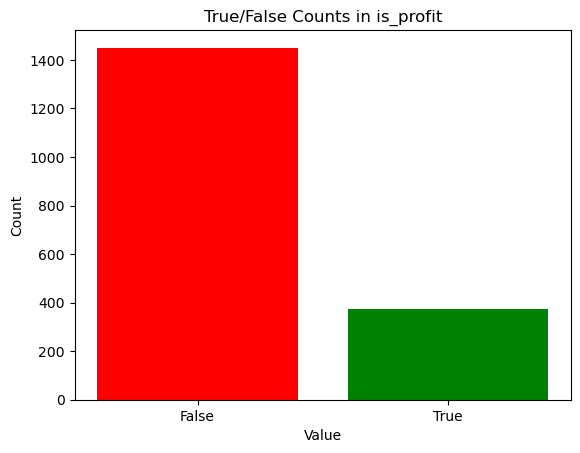

In [37]:
df_results["is_profit"] = df_results["pips"] > 0.0
plot_true_false_counts(df_results, "is_profit")